In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy
import numpy as np
import datetime as dt

In [8]:
DATA_PATH = 'data'

In [66]:
apcp

<xarray.DataArray 'apcp' (time: 2928, lat: 181, lon: 360)>
[190788480 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1844-01-01 ... 1844-12-31T21:00:00
Attributes: (12/14)
    long_name:         3-hourly accumulated total precipitation at surface
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.  13.8]

In [102]:
%%time
apcp = xr.open_dataarray(f'{DATA_PATH}/1844/means/apcp.1844.nc')
apcp_spreads = xr.open_dataarray(f'{DATA_PATH}/1844/spreads/apcp.1844.nc')

min_lon = -100 % 360
min_lat = 38 
max_lon = -88 % 360
max_lat = 45 

cropped_apcp = apcp.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_apcp_spreads = apcp_spreads.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

apcp_daily_avg = cropped_apcp.groupby('time.week').sum('time').mean(['lat', 'lon'])
#time to do a bit of error propogation
apcp_daily_avg_spreads_spatial = np.sqrt(((cropped_apcp_spreads)**2).groupby('time.week').sum('time'))
apcp_daily_avg_spreads = np.sqrt((apcp_daily_avg_spreads_spatial**2).sum(['lat','lon'])) * (1/np.size(apcp_daily_avg_spreads_spatial[0]))

/home/bparazin/anaconda3/envs/1844redux/lib/python3.11/site-packages/xarray/core/accessor_dt.py:408: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


CPU times: user 4.7 s, sys: 108 ms, total: 4.81 s
Wall time: 5.8 s


/home/bparazin/anaconda3/envs/1844redux/lib/python3.11/site-packages/xarray/core/accessor_dt.py:408: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [103]:
%%time
apcp_1993 = xr.open_dataarray(f'{DATA_PATH}/1993/means/apcp.1993.nc')
apcp_spreads_1993 = xr.open_dataarray(f'{DATA_PATH}/1993/spreads/apcp.1993.nc')

min_lon = -100 % 360
min_lat = 38 
max_lon = -88 % 360
max_lat = 45 

cropped_apcp_1993 = apcp_1993.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_apcp_spreads_1993 = apcp_spreads_1993.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

apcp_daily_avg_1993 = cropped_apcp_1993.groupby('time.week').sum('time').mean(['lat', 'lon'])
#time to do a bit of error propogation
apcp_daily_avg_spreads_spatial_1993 = np.sqrt(((cropped_apcp_spreads_1993)**2).groupby('time.week').sum('time'))
apcp_daily_avg_spreads_1993 = np.sqrt((apcp_daily_avg_spreads_spatial_1993**2).sum(['lat','lon'])) * (1/np.size(apcp_daily_avg_spreads_spatial_1993[0]))

/home/bparazin/anaconda3/envs/1844redux/lib/python3.11/site-packages/xarray/core/accessor_dt.py:408: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


CPU times: user 5.02 s, sys: 46.9 ms, total: 5.07 s
Wall time: 6.11 s


/home/bparazin/anaconda3/envs/1844redux/lib/python3.11/site-packages/xarray/core/accessor_dt.py:408: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [94]:
np.size(apcp_daily_avg_spreads_spatial[0])

104

Text(0.5, -0.05, 'Week 14 starts March 31st for 1844 and April 4th for 1993.\nWeek 26 ends June 29th for 1844 and July 3rd for 1993')

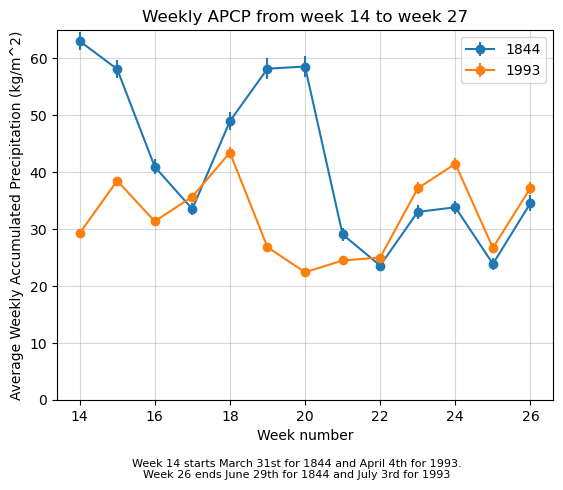

In [115]:
fig, ax = plt.subplots()
week_bounds = slice(14,26)
ax.errorbar(apcp_daily_avg.sel(week=week_bounds)['week'], 
             apcp_daily_avg.sel(week=week_bounds), marker='o', 
             yerr = apcp_daily_avg_spreads.sel(week=week_bounds), label='1844')
ax.errorbar(apcp_daily_avg_1993.sel(week=week_bounds)['week'], 
             apcp_daily_avg_1993.sel(week=week_bounds), marker='o', 
             yerr = apcp_daily_avg_spreads_1993.sel(week=week_bounds), label='1993')
ax.set_ylim(0, 65)
ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Average Weekly Accumulated Precipitation (kg/m^2)')
ax.set_xlabel('Week number')
ax.set_title('Weekly APCP from week 14 to week 27')
txt='Week 14 starts March 31st for 1844 and April 4th for 1993.\nWeek 26 ends June 29th for 1844 and July 3rd for 1993'
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=8)

In [29]:
def crop_nc(netcdf, min_lon = 245.09, min_lat = 27.98, max_lon = 284.22, max_lat = 50.38):
    return netcdf.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

In [31]:
%%time
abs_error_apcp = cropped_apcp_spreads/np.sqrt(80)
lon = cropped_apcp['lon']
lat = cropped_apcp['lat']

CPU times: user 2.69 s, sys: 53.3 ms, total: 2.75 s
Wall time: 3.32 s


In [8]:
def get_rel_error_at_time(mean, spread, time, sample_size=80):
    return (spread.sel(time=time)/np.sqrt(sample_size))/mean.sel(time=time)

Text(0.5, 1.0, 'Absolute standard error in accululated precipitation on October 1st 1844')

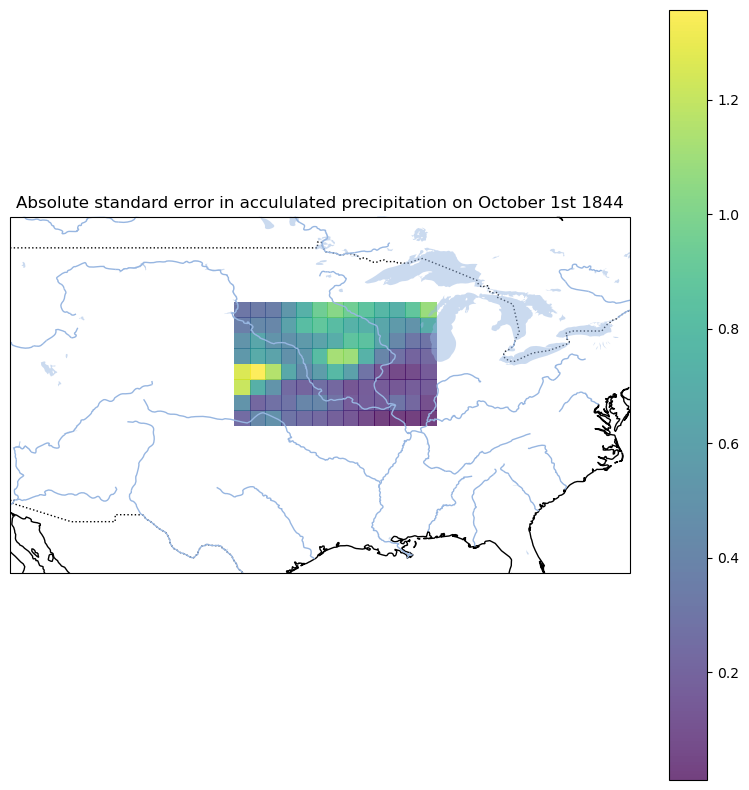

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-115, -75, 28, 51], crs=ccrs.PlateCarree())
im = ax.pcolor(lon, lat, cropped_apcp_spreads.sel(time=dt.datetime(1844, 10,1)), alpha=0.75)
plt.colorbar(im)
ax.set_title('Absolute standard error in accululated precipitation on October 1st 1844')

Text(0.5, 1.0, 'Relative standard error in accululated precipitation on October 1st 1844')

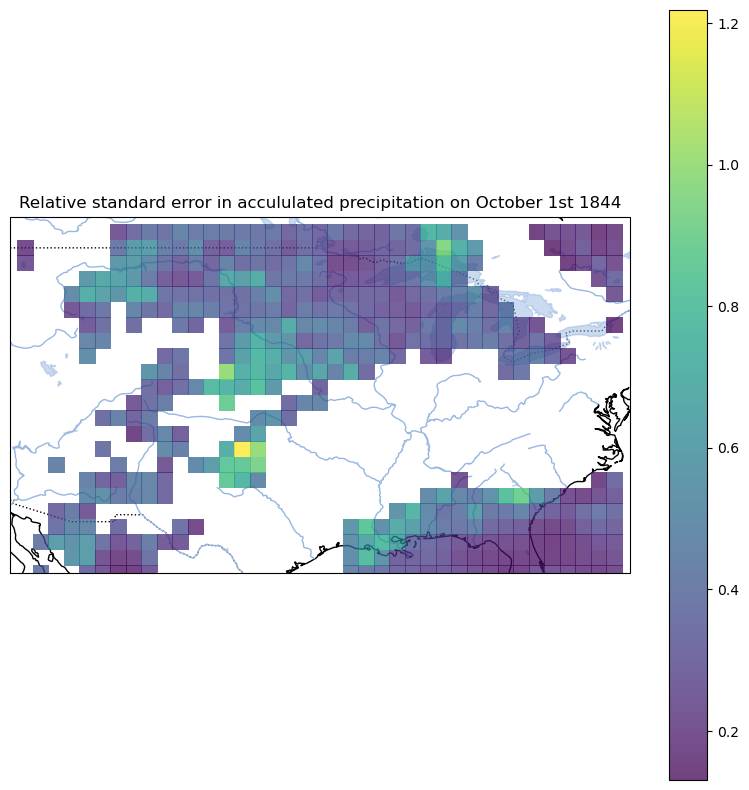

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-115, -75, 28, 51], crs=ccrs.PlateCarree())
im = ax.pcolor(lon, lat, get_rel_error_at_time(cropped_apcp['apcp'], cropped_apcp_spreads['apcp'], dt.datetime(1844, 10,1)), alpha=0.75)
plt.colorbar(im)
ax.set_title('Relative standard error in accululated precipitation on October 1st 1844')

In [11]:
def make_error_plots(varname, datetime, level=None, path=None, min_lon = 250.09, min_lat = 27.98, max_lon = 284.22, max_lat = 55):
    if path is None:
        path = f'D:/data/{datetime.year}'
        
    var_mean_full = xr.open_dataset(f'{path}/means/{varname}.{datetime.year}.nc')
    var_spread_full = xr.open_dataset(f'{path}/spreads/{varname}.{datetime.year}.nc')
    
    var_mean = crop_nc(var_mean_full, min_lon, min_lat, max_lon, max_lat)
    var_spread= crop_nc(var_spread_full, min_lon, min_lat, max_lon, max_lat)
    
    if varname in ['hgt', 'uwnd', 'vwnd']:
        var_mean = var_mean.sel(level=level)
        var_spread = var_spread.sel(level=level)
    
    lon = var_mean['lon']
    lat = var_mean['lat']
    
    fig = plt.figure(figsize=(10,30))
    ax3 = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.COASTLINE)
    ax3.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax3.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax3.add_feature(cartopy.feature.RIVERS)
    ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    im3 = ax3.pcolor(lon, lat, var_mean[varname].sel(time=datetime), alpha=0.75)
    plt.colorbar(im3)
    ax3.set_title(f'{varname} on {datetime}')

    ax1 = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax1.add_feature(cartopy.feature.RIVERS)
    ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    im = ax1.pcolor(lon, lat, get_rel_error_at_time(var_mean[varname], var_spread[varname], datetime), alpha=0.75)
    plt.colorbar(im)
    ax1.set_title(f'Relative error in {varname} on {datetime}')
    
    ax2 = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.COASTLINE)
    ax2.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax2.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax2.add_feature(cartopy.feature.RIVERS)
    ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    im2 = ax2.pcolor(lon, lat, var_spread[varname].sel(time=datetime)/np.sqrt(80), alpha=0.75)
    plt.colorbar(im2)
    ax2.set_title(f'Absolute standard error in {varname} on {datetime}')

CPU times: total: 328 ms
Wall time: 326 ms


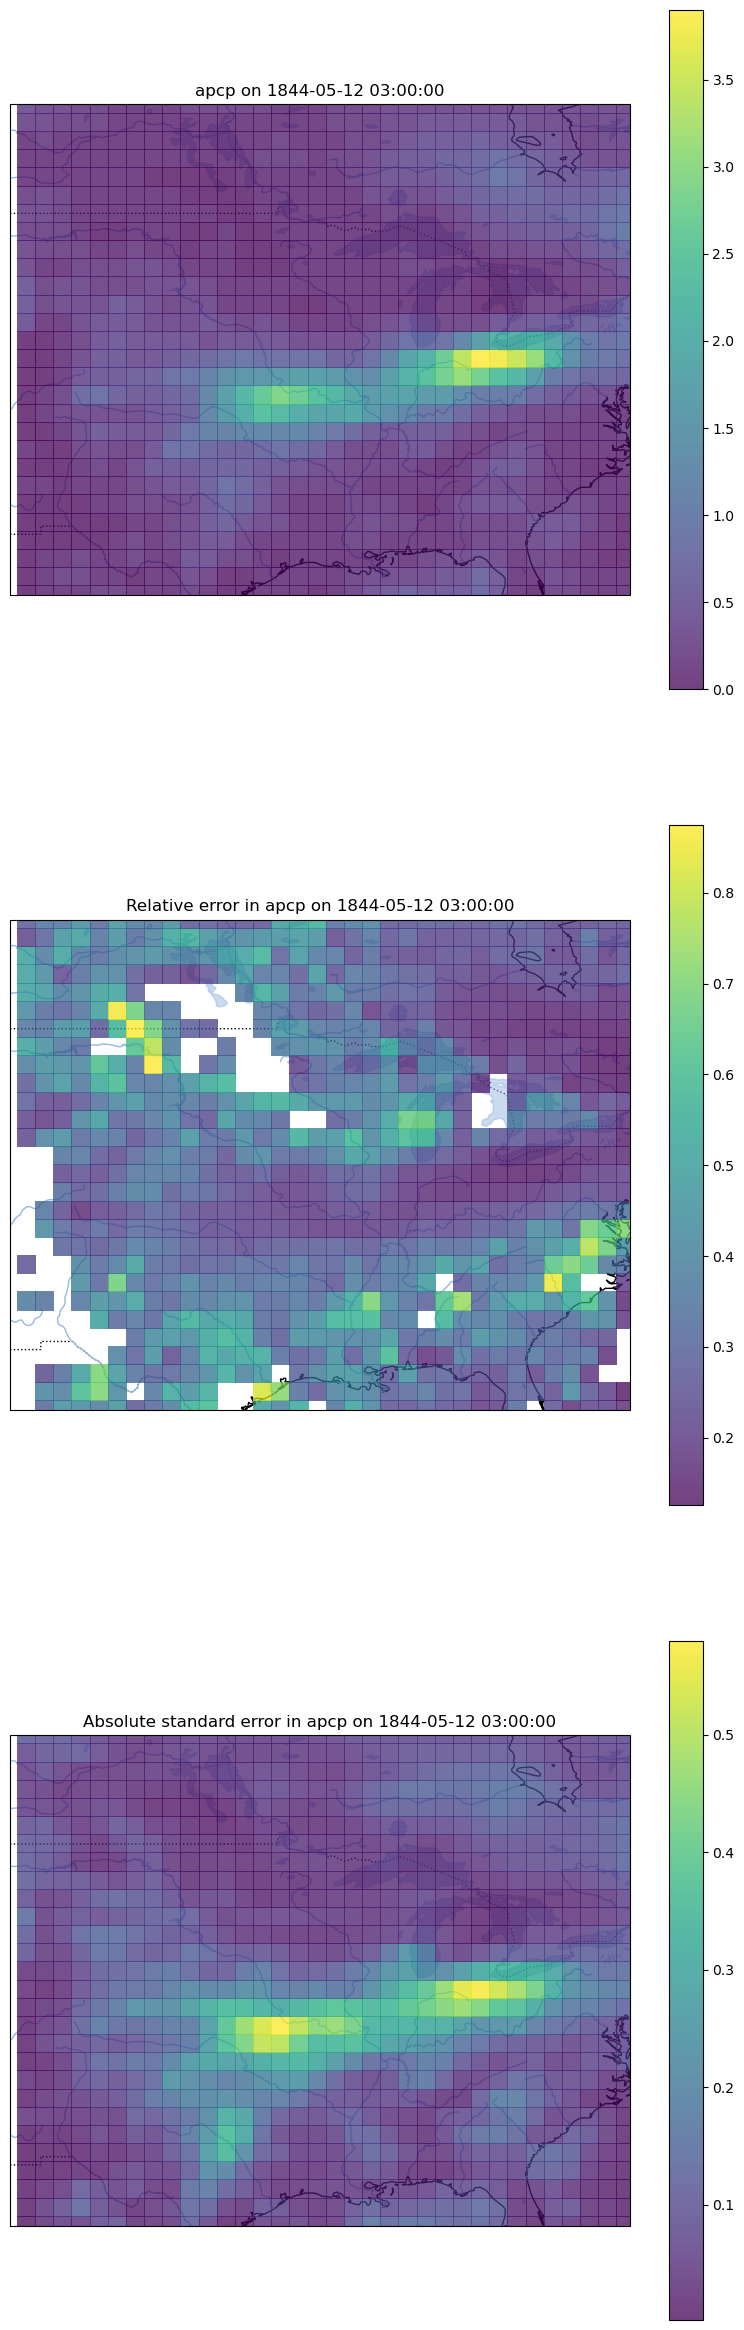

In [12]:
%%time
make_error_plots('apcp', dt.datetime(1844, 5, 12, 3), level=1000)

In [13]:
def make_storm_animation(varname, datetime, level=None, path=None, min_lon = 250.09, min_lat = 27.98, max_lon = 284.22, max_lat = 55):
    if path is None:
        path = f'D:/data/{datetime.year}'
        
    var_mean_full = xr.open_dataset(f'{path}/means/{varname}.{datetime.year}.nc')
    var_spread_full = xr.open_dataset(f'{path}/spreads/{varname}.{datetime.year}.nc')
    
    var_mean = crop_nc(var_mean_full, min_lon, min_lat, max_lon, max_lat)
    var_spread= crop_nc(var_spread_full, min_lon, min_lat, max_lon, max_lat)
    
    if varname in ['hgt', 'uwnd', 'vwnd']:
        var_mean = var_mean.sel(level=level)
        var_spread = var_spread.sel(level=level)
    
    lon = var_mean['lon']
    lat = var_mean['lat']
    
    fig = plt.figure(figsize=(10,10))
    ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.COASTLINE)
    ax3.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax3.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax3.add_feature(cartopy.feature.RIVERS)
    ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    def plot_storm(steps_plus):
    
        im3 = ax3.pcolor(lon, lat, var_mean[varname].sel(time=datetime + dt.timedelta(hours = 3 * steps_plus)), alpha=0.75)
        cbar = plt.colorbar(im3)
        return [im3, cbar]
    
    anim = FuncAnimation(fig, plot_storm)
    plt.show()
    
    ax3.set_title(f'{varname} on {datetime}')

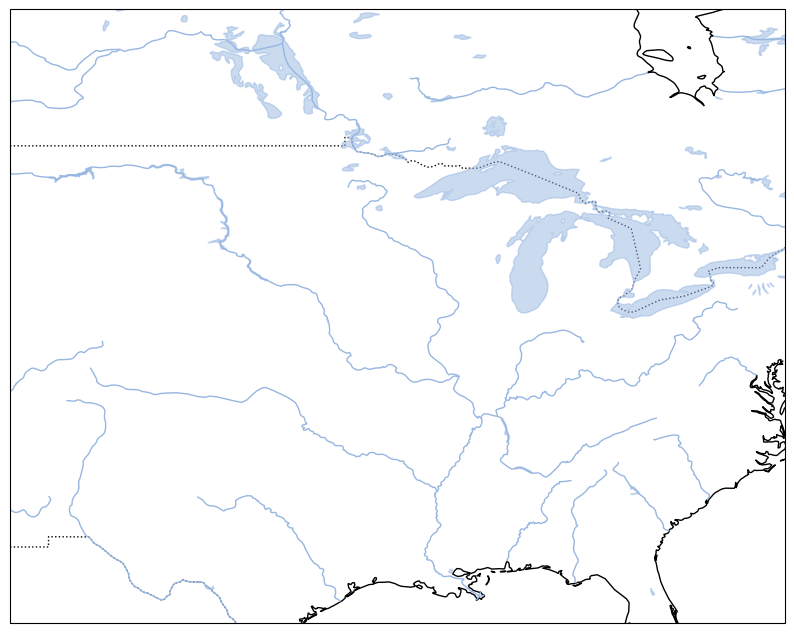

CPU times: total: 125 ms
Wall time: 130 ms


C:\Users\bpara\anaconda3\envs\esslab\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [14]:
%%time
make_storm_animation('apcp', dt.datetime(1844, 5, 12, 3), level=1000)

In [54]:
import storm_animation